In [1]:
import libsimulation
from src import main

import os, datetime, argparse, requests, urllib.parse, sys, re, traceback, json
import math, numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# NBA data jupyter notebook

__Important__
This notebook is here for you to quickly test with the data.
It is __not__ the final submission, as we will only run your code provided in `src/main.py` and any other files referenced from it.

## Set up some environmental settings

In [2]:
# Initialize some settings
settings = libsimulation.SimulationSettings()
settings.env = 'prod'
## Ensure we don't use data beyond this cutoff
settings.cutoff = '2019-01-01'
settings.resultpath = None

## Set up a basic predict method that generates silly, cosntant, predictions

In [ ]:
# Write some code
def predict(required_predictions, data_loader):
    # Load games data for the 2011 season.
    # Seasons from 2009 onwards are available, including POST seasons, such as 2011POST
    games2011 = data_loader.getSeason('2011')
    print(f'Loaded {len(games2011)} 2011 games')
    print(f'First entry in 2011 season is\n{games2011.iloc[[0]]}')

    # Loading a season that is ahead of the cutoff training time returns no results.
    # In this case, the default cutoff time is in 2019, so loading 2020 data returns no results.
    # You can change the cutoff time by passing to simulate.py
    #     --cutoff YYYY-MM-DD
    games2020 = data_loader.getSeason('2020')
    print(f'Loaded {len(games2020)} 2020 games')

    # You can load an individual match's data
    aGame = data_loader.getGame(games2011.loc[100, 'gameId'])
    print(f'Game 100 in the 2011 database is\n{aGame}')

    # You can also load the full players data for an entire season
    full2011seasonPlayers = data_loader.getPlayers('2011')
    print(f'Loaded {len(full2011seasonPlayers)} 2011 season player rows')

    print(f'Required predictions are\n{required_predictions}')

    # You should fill in the sum and diff fields of the required predictions
    for index, match in required_predictions.iterrows():
        required_predictions.at[index, 'sum'] = 999
        required_predictions.at[index, 'diff'] = 1
    print('finished')

## Run a simulation

In [ ]:
# Run a simulation
settings.predict = predict
libsimulation.runSimulation(settings)

In [ ]:
# You can also run the code present in src/main.py
settings.predict = main.predict
libsimulation.runSimulation(settings)

# Exploring data

In [ ]:
data_loader = libsimulation.NbaDataLoader(settings)

In [ ]:
data_loader.getSeason('2011')

In [ ]:
data_loader.getSeason('2018POST')

In [ ]:
data_loader.getGame(5210)

In [ ]:
data_loader.getPlayers('2011')

# Building and Testing a model

## Load some data into train and validaiton sets

In [17]:
importlib.reload(libsimulation)

<module 'libsimulation' from 'S:\\jeremym\\jeremymardon898_nba2019-master\\libsimulation.py'>

In [18]:
data_loader = libsimulation.NbaDataLoader(settings)

In [19]:
def get_multi_season_game_data(data_loader, first_year, last_year):
    data = [pd.DataFrame(data_loader.getSeason(str(season))) for season in range(first_year, last_year + 1)]
    data = pd.concat(data, axis=0)
    data.dropna(axis=0, inplace=True)
    data.dateTime=pd.to_datetime(data.dateTime)
    data.sort_values('dateTime', inplace=True)
    data.reset_index(inplace=True, drop=True)
    return data

In [21]:
train_data = get_multi_season_game_data(data_loader, 2009, 2016)
test_data = get_multi_season_game_data(data_loader, 2017, 2018)

In [22]:
train_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,awayMinutes,awayRebounds,awayScore,awaySteals,quarter0away,quarter1away,quarter2away,quarter3away,season,status
0,6265,2008-10-28 20:00:00,BOS,CLE,5.0,175.0,0.0,240.0,36.0,90.0,...,240.0,41.0,85.0,8.0,28.0,22.0,13.0,22.0,2009,Final
1,6266,2008-10-28 20:30:00,CHI,MIL,13.0,203.0,6.0,240.0,40.0,108.0,...,240.0,32.0,95.0,5.0,26.0,26.0,23.0,20.0,2009,Final
2,6267,2008-10-28 22:30:00,LAL,POR,20.0,172.0,7.0,240.0,49.0,96.0,...,240.0,44.0,76.0,8.0,14.0,20.0,19.0,23.0,2009,Final
3,6268,2008-10-29 18:00:00,PHI,TOR,-11.0,179.0,8.0,240.0,56.0,84.0,...,240.0,33.0,95.0,8.0,18.0,33.0,23.0,21.0,2009,Final
4,6270,2008-10-29 19:00:00,WAS,BKN,-10.0,180.0,5.0,240.0,41.0,85.0,...,240.0,37.0,95.0,7.0,23.0,21.0,25.0,26.0,2009,Final


In [23]:
test_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,awayMinutes,awayRebounds,awayScore,awaySteals,quarter0away,quarter1away,quarter2away,quarter3away,season,status
0,9642,2016-10-25 19:30:00,CLE,NY,29.0,205.0,5.0,240.0,51.0,117.0,...,240.0,42.0,88.0,6.0,18.0,27.0,19.0,24.0,2017,Final
1,9643,2016-10-25 22:00:00,POR,UTA,9.0,217.0,3.0,239.0,34.0,113.0,...,240.0,31.0,104.0,9.0,26.0,20.0,37.0,21.0,2017,Final
2,9644,2016-10-25 22:30:00,GS,SA,-29.0,229.0,6.0,240.0,35.0,100.0,...,240.0,55.0,129.0,13.0,31.0,33.0,33.0,32.0,2017,Final
3,9645,2016-10-26 19:00:00,IND,DAL,9.0,251.0,6.0,265.0,52.0,130.0,...,265.0,49.0,121.0,8.0,21.0,31.0,33.0,30.0,2017,F/OT
4,9646,2016-10-26 19:00:00,ORL,MIA,-12.0,204.0,4.0,240.0,45.0,96.0,...,240.0,52.0,108.0,5.0,23.0,27.0,30.0,28.0,2017,Final


## Define some functions to calcuate a Elo ratings over time

In [60]:
## Elo model's probability of home team winning
def home_win_probability(home_elo, away_elo):
    return 1 / (1 + math.pow(10, -(home_elo - away_elo) / 400)) 

## Get new Elo ratings home and away teams after a game
def get_updated_elo(
    home_elo, away_elo, 
    home_victory, ## 1 if home team won, 0 if away team won
    K,  ## model hyperparameter 
): 
    if home_victory not in [0, 1, False, True]:
        raise ValueError(f"home_victory should be 1 if home team won, 0 if away team won. Got {home_victory}")

    P_home_win = home_win_probability(home_elo, away_elo) 
    P_away_win = 1 - P_home_win
  
    # When home team wins 
    if home_victory : 
        home_elo += K * P_away_win
        away_elo -= K * P_home_win
      
    # When away team wins 
    else : 
        home_elo -= K * P_away_win
        away_elo += K * P_home_win
        
    return home_elo, away_elo

## Iterate through games updating each teams Elo rating
def get_elos_over_time(data, ## dataframe of games, must be in order of occurence
                      starting_elo_dict={},  ## dictionary of elo scores by team at the beginning of the data period
                      default_elo=0,  ## elo initally given to a team not in starting_elo_dict
                      K=10,  ## model hyperparameter; higher number means individuals game affects Elo more
                     ):
    
    elo_dict = starting_elo_dict.copy()
    data['homeElo'] = np.nan
    data['awayElo'] = np.nan

    ## Iterate over rows of the dataframe (i.e. over games)
    for i, row in data.iterrows():
        
        home_team = row['homeTeam']
        away_team = row['awayTeam']
        home_elo = elo_dict.get(home_team, default_elo)
        away_elo = elo_dict.get(away_team, default_elo)
        
        ## Put the team's current ELO in the dataframe (this is the teams ELO *before* the match)
        data.loc[i,'homeElo'] = home_elo
        data.loc[i,'awayElo'] = away_elo
        
        ## Calculate the new elo scores and update elo_dict with them
        home_victory = row['pointsDiff'] > 0
        home_elo, away_elo = get_updated_elo(home_elo, away_elo, home_victory, K)
        elo_dict[home_team] = home_elo
        elo_dict[away_team] = away_elo
    
    return elo_dict

In [61]:
K = 10
pre_test_elo_dict = get_elos_over_time(train_data, starting_elo_dict={}, K=K)
post_test_elo_dict = get_elos_over_time(test_data, starting_elo_dict=pre_test_elo_dict, K=K)

In [62]:
train_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,awayScore,awaySteals,quarter0away,quarter1away,quarter2away,quarter3away,season,status,homeElo,awayElo
0,6265,2008-10-28 20:00:00,BOS,CLE,5.0,175.0,0.0,240.0,36.0,90.0,...,85.0,8.0,28.0,22.0,13.0,22.0,2009,Final,0.0,0.0
1,6266,2008-10-28 20:30:00,CHI,MIL,13.0,203.0,6.0,240.0,40.0,108.0,...,95.0,5.0,26.0,26.0,23.0,20.0,2009,Final,0.0,0.0
2,6267,2008-10-28 22:30:00,LAL,POR,20.0,172.0,7.0,240.0,49.0,96.0,...,76.0,8.0,14.0,20.0,19.0,23.0,2009,Final,0.0,0.0
3,6268,2008-10-29 18:00:00,PHI,TOR,-11.0,179.0,8.0,240.0,56.0,84.0,...,95.0,8.0,18.0,33.0,23.0,21.0,2009,Final,0.0,0.0
4,6270,2008-10-29 19:00:00,WAS,BKN,-10.0,180.0,5.0,240.0,41.0,85.0,...,95.0,7.0,23.0,21.0,25.0,26.0,2009,Final,0.0,0.0


In [63]:
test_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,awayScore,awaySteals,quarter0away,quarter1away,quarter2away,quarter3away,season,status,homeElo,awayElo
0,9642,2016-10-25 19:30:00,CLE,NY,29.0,205.0,5.0,240.0,51.0,117.0,...,88.0,6.0,18.0,27.0,19.0,24.0,2017,Final,-207.640847,-508.064454
1,9643,2016-10-25 22:00:00,POR,UTA,9.0,217.0,3.0,239.0,34.0,113.0,...,104.0,9.0,26.0,20.0,37.0,21.0,2017,Final,64.598944,-339.203693
2,9644,2016-10-25 22:30:00,GS,SA,-29.0,229.0,6.0,240.0,35.0,100.0,...,129.0,13.0,31.0,33.0,33.0,32.0,2017,Final,135.967988,389.252603
3,9645,2016-10-26 19:00:00,IND,DAL,9.0,251.0,6.0,265.0,52.0,130.0,...,121.0,8.0,21.0,31.0,33.0,30.0,2017,F/OT,-84.771266,95.114479
4,9646,2016-10-26 19:00:00,ORL,MIA,-12.0,204.0,4.0,240.0,45.0,96.0,...,108.0,5.0,23.0,27.0,30.0,28.0,2017,Final,-471.783918,227.936689


## Look at Elo ratings over time

In [113]:
def plot_team_elo_over_time(data, team):
    team_data = data.query(f'homeTeam == "{team}" | awayTeam == "{team}"').copy()
    team_data['Elo'] = team_data.eval(f'(homeTeam == "{team}") * homeElo + (awayTeam == "{team}") * awayElo')
    team_data = team_data[['dateTime', 'gameId', 'Elo']]
    plt.plot(team_data['dateTime'], team_data['Elo'], label=team)

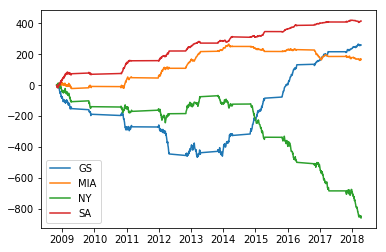

In [114]:
combined_data = pd.concat([train_data, test_data])
for team in ['GS', 'MIA', 'NY', 'SA']:
    plot_team_elo_over_time(combined_data, team)
plt.legend();

## Fit a linear model on our train data

In [64]:
train_data['EloDifference'] = train_data['homeElo'] - train_data['awayElo']
test_data['EloDifference'] = test_data['homeElo'] - test_data['awayElo']
train_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,awaySteals,quarter0away,quarter1away,quarter2away,quarter3away,season,status,homeElo,awayElo,EloDifference
0,6265,2008-10-28 20:00:00,BOS,CLE,5.0,175.0,0.0,240.0,36.0,90.0,...,8.0,28.0,22.0,13.0,22.0,2009,Final,0.0,0.0,0.0
1,6266,2008-10-28 20:30:00,CHI,MIL,13.0,203.0,6.0,240.0,40.0,108.0,...,5.0,26.0,26.0,23.0,20.0,2009,Final,0.0,0.0,0.0
2,6267,2008-10-28 22:30:00,LAL,POR,20.0,172.0,7.0,240.0,49.0,96.0,...,8.0,14.0,20.0,19.0,23.0,2009,Final,0.0,0.0,0.0
3,6268,2008-10-29 18:00:00,PHI,TOR,-11.0,179.0,8.0,240.0,56.0,84.0,...,8.0,18.0,33.0,23.0,21.0,2009,Final,0.0,0.0,0.0
4,6270,2008-10-29 19:00:00,WAS,BKN,-10.0,180.0,5.0,240.0,41.0,85.0,...,7.0,23.0,21.0,25.0,26.0,2009,Final,0.0,0.0,0.0


In [116]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X=train_data[['EloDifference']], y=train_data['pointsDiff'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [117]:
## Use the statsmodels library to fit a linear model of Elo difference to points difference
X = train_data['EloDifference']
y = train_data['pointsDiff']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pointsDiff   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     284.3
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           9.83e-63
Time:                        12:23:03   Log-Likelihood:                -32586.
No. Observations:                8116   AIC:                         6.517e+04
Df Residuals:                    8115   BIC:                         6.518e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
EloDifference     0.0049      0.000     16.863      0.000       0.004       0.005
==============================================================================
Omnibus:                      226.965   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              514.349
Skew:                           0.131   Prob(JB):                    2.04e-112
Kurtosis:                       4.205   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X=train_data[['EloDifference']], y=train_data['pointsSum'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [70]:
## Use the statsmodels library to fit a linear model of Elo difference to points difference
train_data['EloSum'] = train_data['homeElo'] + train_data['awayElo']
test_data['EloSum'] = test_data['homeElo'] + test_data['awayElo']
X = train_data[['EloDifference', 'EloSum']]
X = sm.add_constant(X)
y = train_data['pointsDiff']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pointsDiff   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     152.1
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           1.36e-65
Time:                        12:44:22   Log-Likelihood:                -32385.
No. Observations:                8116   AIC:                         6.478e+04
Df Residuals:                    8113   BIC:                         6.480e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.1317      0.173     18.087      0.000       2.792       3.471
EloDifference     0.0049      0.000     17.312      0.000       0.004       0.005
EloSum            0.0006      0.000      2.130      0.033    4.55e-05       0.001
==============================================================================
Omnibus:                      229.910   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.005
Skew:                           0.132   Prob(JB):                    1.64e-114
Kurtosis:                       4.217   Cond. No.                         769.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Make some predicitons on the test set

In [118]:
X_test = test_data['EloDifference']
test_data['predictedDiff'] = fitted_model.predict(X_test)
test_data.head()

,gameId,dateTime,homeTeam,awayTeam,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeScore,...,quarter0away,quarter1away,quarter2away,quarter3away,season,status,homeElo,awayElo,EloDifference,predictedDiff
0,9642,2016-10-25 19:30:00,CLE,NY,29.0,205.0,5.0,240.0,51.0,117.0,...,18.0,27.0,19.0,24.0,2017,Final,-207.640847,-508.064454,300.423606,1.465542
1,9643,2016-10-25 22:00:00,POR,UTA,9.0,217.0,3.0,239.0,34.0,113.0,...,26.0,20.0,37.0,21.0,2017,Final,64.598944,-339.203693,403.802637,1.969851
2,9644,2016-10-25 22:30:00,GS,SA,-29.0,229.0,6.0,240.0,35.0,100.0,...,31.0,33.0,33.0,32.0,2017,Final,135.967988,389.252603,-253.284615,-1.235586
3,9645,2016-10-26 19:00:00,IND,DAL,9.0,251.0,6.0,265.0,52.0,130.0,...,21.0,31.0,33.0,30.0,2017,F/OT,-84.771266,95.114479,-179.885746,-0.877528
4,9646,2016-10-26 19:00:00,ORL,MIA,-12.0,204.0,4.0,240.0,45.0,96.0,...,23.0,27.0,30.0,28.0,2017,Final,-471.783918,227.936689,-699.720607,-3.413413


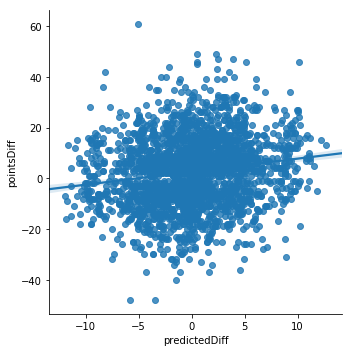

In [119]:
## Check how good our predictions are
sns.lmplot('predictedDiff', 'pointsDiff', test_data);

In [120]:
## remodel to see statistics on test data
X = test_data['predictedDiff']
y = test_data['pointsDiff']
test_model = sm.OLS(y, X).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pointsDiff   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     64.65
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           1.38e-15
Time:                        12:23:03   Log-Likelihood:                -9937.3
No. Observations:                2460   AIC:                         1.988e+04
Df Residuals:                    2459   BIC:                         1.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
predictedDiff     0.5131      0.064      8.040      0.000       0.388       0.638
==============================================================================
Omnibus:                       11.760   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.711
Skew:                           0.066   Prob(JB):                     0.000639
Kurtosis:                       3.355   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Set up a prediction method to incorporate the Elo model and return valid predictions

In [75]:
# Write some code
def predict(required_predictions, data_loader, log=lambda x: print(x)):
    first_year = 2016
    
    log('Loading training data')
    train_data = get_multi_season_game_data(data_loader, first_year=first_year, last_year=2020)
    
    log('Getting Elo ratings over time on train data')
    elo_dict = get_elos_over_time(train_data, starting_elo_dict={}, K=10)
    train_data['EloDifference'] = train_data['homeElo'] - train_data['awayElo']
    train_data['EloSum'] = train_data['homeElo'] + train_data['awayElo']
    
    log('Fitting linear model from Elo difference and sum to points difference')
    X = train_data[['EloDifference', 'EloSum']]
    X = sm.add_constant(X)
    y = train_data['pointsDiff']
    diff_model = sm.OLS(y, X).fit()
    
    log('Fitting linear model from Elo difference and sum to points sum')
    y = train_data['pointsSum']
    sum_model = sm.OLS(y, X).fit()
    
    log('Generating predictions')
#     required_predictions = pd.DataFrame(required_predictions)
    tmp = required_predictions[['homeTeam', 'awayTeam']].copy()
    tmp['homeElo'] = [elo_dict[team] for team in tmp['homeTeam']]
    tmp['awayElo'] = [elo_dict[team] for team in tmp['awayTeam']]
    tmp['EloDifference'] = tmp.eval('homeElo - awayElo')
    tmp['EloSum'] = tmp.eval('homeElo + awayElo')
    X = tmp[['EloDifference', 'EloSum']]
    X = sm.add_constant(X)
    tmp['predictedDiff'] = diff_model.predict(X)
    tmp['predictedSum'] = sum_model.predict(X)
    
    required_predictions['predictedDiff'] = tmp['predictedDiff']
    required_predictions['predictedSum'] = tmp['predictedSum']
    
    log('Finished')
    
#     return required_predictions.to_dict('records')
    return required_predictions

In [76]:
## 
required_predictions = test_data[:300][['homeTeam', 'awayTeam', 'dateTime', 'gameId']]
required_predictions = predict(required_predictions, data_loader)

Loading training data
Getting Elo ratings over time on train data
Fitting linear model from Elo difference and sum to points difference
Fitting linear model from Elo difference and sum to points sum
Generating predictions
Finished


In [89]:
required_predictions.head()

,homeTeam,awayTeam,dateTime,gameId,predictedDiff,predictedSum
0,CLE,NY,2016-10-25 19:30:00,9642,10.377105,215.376327
1,POR,UTA,2016-10-25 22:00:00,9643,2.715057,209.703010
2,GS,SA,2016-10-25 22:30:00,9644,3.898871,205.084536
3,IND,DAL,2016-10-26 19:00:00,9645,6.783833,212.572520
4,ORL,MIA,2016-10-26 19:00:00,9646,-3.975014,213.225348


In [90]:
def single_game_error(predictedDiff, predictedSum, actualDiff, actualSum):
    return abs(predictedDiff - actualDiff) + abs(predictedSum - actualSum)

def score_predictions(predictions):
    x1 = predictions['predictedDiff']
    x2 = predictions['predictedSum']
    y1 = predictions['pointsDiff']
    y2 = predictions['pointsSum']
    
    ## baseline model 
    x1_baseline = 0  ## no information about who will win
    x2_baseline = 200  ## avergae points total between 2009 and 2016 seasons
    
    predictions['error'] = single_game_error(x1, x2, y1, y2)
    predictions['baseline_error'] = single_game_error(x1_baseline, x2_baseline, y1, y2)
    
    predictions['score'] = predictions.eval('baseline_error - error')
    
    return predictions.score.sum()

In [91]:
tmp = pd.merge(required_predictions[['gameId', 'predictedDiff', 'predictedSum']], test_data[['gameId', 'pointsDiff', 'pointsSum']], on='gameId', how='left')
score_predictions(tmp)

416.5923679499866

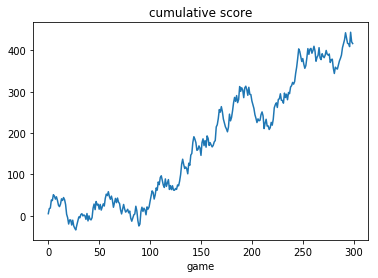

In [93]:
plt.plot(np.cumsum(tmp['score']))
plt.xlabel('game')
plt.title('cumulative score');

In [26]:
# Run a simulation
settings.predict = predict
libsimulation.runSimulation(settings)

Loading prediction matches starting from 2019-01-01
Starting call to user defined function
Loading training data
Getting Elo ratings over time on train data
Fitting linear model from Elo difference to points difference
Generating predictions
Finished
User defined function completed
Game 13029. Actual results: home 122 - away 116. Actual: sum 238 - diff 6. Predicted results: sum 220.0 - diff 0.6778474226373055
Game 13030. Actual results: home 121 - away 98. Actual: sum 219 - diff 23. Predicted results: sum 220.0 - diff 0.596049349154762
Game 13031. Actual results: home 115 - away 108. Actual: sum 223 - diff 7. Predicted results: sum 220.0 - diff 3.372126235821934
Game 13032. Actual results: home 108 - away 113. Actual: sum 221 - diff -5. Predicted results: sum 220.0 - diff -7.9243822262224075
Game 13033. Actual results: home 113 - away 119. Actual: sum 232 - diff -6. Predicted results: sum 220.0 - diff 4.989176633435239
Game 13036. Actual results: home 84 - away 122. Actual: sum 206 - d